# Segmentation Experiment 
--- 

8.4.2020 

Addressing issue of injective mapping producing spurious weighting in GPA, cleaning up code 

In [9]:
import numpy as np
import os 
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


In [2]:
save_path = "/Users/Alex/Documents/TaylorLab/segmentation_raw/"


In [3]:
segmentation_list = [
("/Users/Alex/Downloads/IR_134/Segmentation RT 134/Segmentation RT 134.seg.nrrd", "Segmentation RT 134"),
("/Users/Alex/Downloads/IR_134/Segmentation LT 134/Segmentation LT 134.seg.nrrd", "Segmentation LT 134"),
("/Users/Alex/Downloads/IR_138/Segmentation RT 138/Segmentation RT 138.seg.nrrd", "Segmentation RT 138"),
("/Users/Alex/Downloads/IR_138/Segmentation LT 138/Segmentation LT 138.seg.nrrd", "Segmentation LT 138"),
("/Users/Alex/Downloads/IR_140/Segmentation RT 140/Segmentation RT 140.seg.nrrd", "Segmentation RT 140"),
("/Users/Alex/Downloads/IR_140/Segmentation LT 140/Segmentation LT 140.seg.nrrd", "Segmentation LT 140"),
("/Users/Alex/Downloads/IR_144/Segmentation RT 144/Segmentation RT 144.seg.nrrd", "Segmentation RT 144"),
("/Users/Alex/Downloads/IR_144/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 144"),
("/Users/Alex/Downloads/IR_146/Segmentation RT 146/Segmentation RT 146.seg.nrrd", "Segmentation RT 146"),
("/Users/Alex/Downloads/IR_146/Segmentation LT 146/Segmentation LT 146.seg.nrrd", "Segmentation LT 146"),
("/Users/Alex/Downloads/IR_148/Segmentation LT 148/Segmentation LT 148.seg.nrrd", "Segmentation LT 148"),
("/Users/Alex/Downloads/IR_150/Segmentation RT 150/Segmentation RT 150.seg.nrrd", "Segmentation RT 150"),
("/Users/Alex/Downloads/IR_150/Segmentation LT 150/Segmentation LT 150.seg.nrrd", "Segmentation LT 150"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation RT lly/Segmentation RT 144.seg.nrrd", "Segmentation RT 147"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 147"),
]

In [27]:
def compute_mapping(initial_shape, shape):
    
    M = np.dot(shape, initial_shape.T)
    te = np.square(shape).sum(axis=1)
    tr = np.square(initial_shape).sum(axis=1)
    dists = np.array(np.sqrt(-2*M + np.matrix(tr) + np.matrix(te).T))

    return np.amin(dists, axis=0), np.argmin(dists, axis=0) 

In [43]:
def correspondences(bigboy, initial_guess_id=0, n_downsampled=1300): 
    
    initial_guess_id = 0
    indices = np.random.randint(0, bigboy[initial_guess_id].shape[0]-1, size=n_downsampled)
    initial_shape = bigboy[initial_guess_id][indices]
    
#     nfeat = initial_shape.shape(0)
#     initial_shape = initial_shape.reshape((nfeat/3, 3), order="F")
    
    block_sz = 300
    mappings = []
    
    for i, shape in enumerate(bigboy): 
        
        if i == initial_guess_id: 
            continue
        
        candidate_mins = []
        candidate_indices = []
#         nfeat = shape.shape(0)
#         shape = shape.reshape((nfeat/3, 3), order="F")
        
        shape_indices = np.arange(len(shape))
        n_splits = len(shape_indices)//block_sz
        
        for i in range(n_splits):

            
            cur_idx = shape_indices[block_sz*i:block_sz*(i+1)]

            if i == n_splits - 1:
                cur_idx = shape_indices[block_sz*i:block_sz*(i+1) - len(shape_indices)]

            mins, indices = compute_mapping(initial_shape, shape[cur_idx])

            candidate_mins.append(mins)
            candidate_indices.append(indices)
        
        
        mapping = []
#         for j, (dists, idxs) in enumerate(zip(candidate_mins, candidate_indices)):
        stacked_mins = np.stack(candidate_mins, axis=1)
        stacked_indices = np.stack(candidate_indices, axis=1)
#         print(stacked_mins.shape, stacked_indices.shape)
#         print np.argmin(stacked_mins, axis=1)
        mapping = stacked_indices[np.arange(len(stacked_indices)), np.argmin(stacked_mins, axis=1)]
#         print mapping.shape
#         mapping[j] = list(zip(dist, idxs))[1]
        
        mappings.append(mapping)
        
    mappings.insert(initial_guess_id, indices)
    
    return mappings
        

In [5]:
def correspondences(feature_array, initial_guess_id=0): 
    
    _, nfeat = feature_array.shape
    initial_guess = feature_array[initial_guess_id].reshape((nfeat/3, 3), order="F")
    
    for i, shape in enumerate(feature_array): 
        if i == initial_guess_id: 
            continue 
        shape = shape.reshape((nfeat/3, 3), order="F")
        mapping = compute_mapping(initial_guess, shape)
        feature_array[i] = shape[mapping,:].T.reshape(nfeat)
    
    
    return feature_array

## Generalized Procrustes Analysis

In [19]:
def procrustes_loop(X, tol=.01, initial_guess_id=0, n_iter = 40): 

    print("procrustes function")
    nshape, nfeat, _ = X.shape
    initial_shape = X[initial_guess_id] #.reshape((nfeat/3, 3), order="F")

    aligned = np.zeros(X.shape)

    # procrustes loop
    for iteration in range(n_iter): 
        print("procrustes iter: ", iteration)
    
        #  alignment to mean shape or initial guess
        max_disparity = 0.0
        
        for i, shape in enumerate(X):
            
            if iteration == 0 and i == initial_guess_id: 
                # skip the first iteration, first shape because that's our initial guess for the mean
#                 aligned[initial_guess_id] = np.transpose(initial_shape).reshape(nfeat)
                continue 
                
#             shape = shape.reshape((nfeat/3, 3), order="F")
            
            if iteration == 0 and i != initial_guess_id: 
                disparity = np.sum(np.square(shape - initial_shape))
                print "baseline disp for shape %d"%(i + 1), disparity
            
            R, s = orthogonal_procrustes(shape, initial_shape)
            shape = shape.dot(R) 
        
            disparity = np.sum(np.square(shape - initial_shape))
            
            if disparity > max_disparity:
                max_disparity = disparity
                
            print "inner disp:", disparity
            
            X[i] = shape
#             X[i] = np.transpose(shape).reshape(nfeat)
            
            
        # (re)compute the mean shape
        
        mean_shape = np.mean(X, axis=0)
#         mean_shape = np.mean(X.reshape((nshape, nfeat/3, 3), order='F'), axis=0)
        mean_shape, initial_shape, disparity = procrustes(mean_shape, initial_shape)
        R_mean, scale_mean = orthogonal_procrustes(initial_shape, mean_shape)
    
        disparity = np.sum(np.square(initial_shape - mean_shape))

        # check if mean shape has changed
        if max_disparity > tol: 
            print(disparity)
            initial_shape = mean_shape

        else:
            print(disparity)
            break

    return X

## Unaligned Projection View

<IPython.core.display.Javascript object>


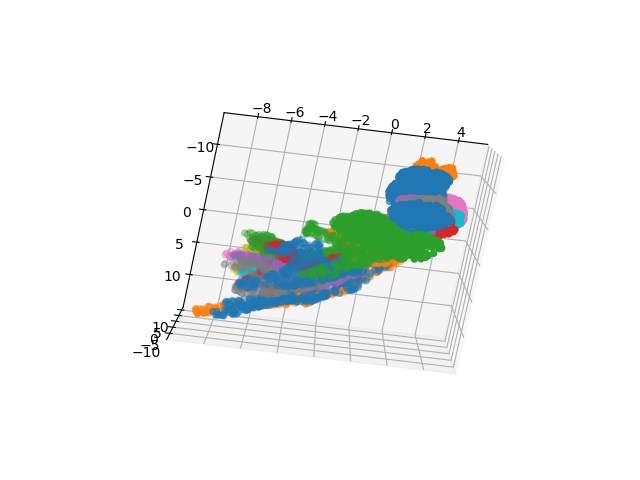

In [10]:
bigboy = []
n_downsampled = 1100
np.random.seed(2020)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for seg_path, identifier in segmentation_list[:-1]:
    keep_id = 9
    identifier = identifier.replace(" ", "")
    
    point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices = np.random.randint(0, point_cloud.shape[0]-1, size=n_downsampled)
    point_cloud = point_cloud - np.mean(point_cloud, axis=0)
    if "LT" in identifier: 
        point_cloud[:,0] = -1.*point_cloud[:,0]
    
    point_cloud = point_cloud[indices]
    ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2])



## Alignment; Plot shapes

(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
(1700,)
[(1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3), (1700, 3)]
(14, 1700, 3)


<IPython.core.display.Javascript object>


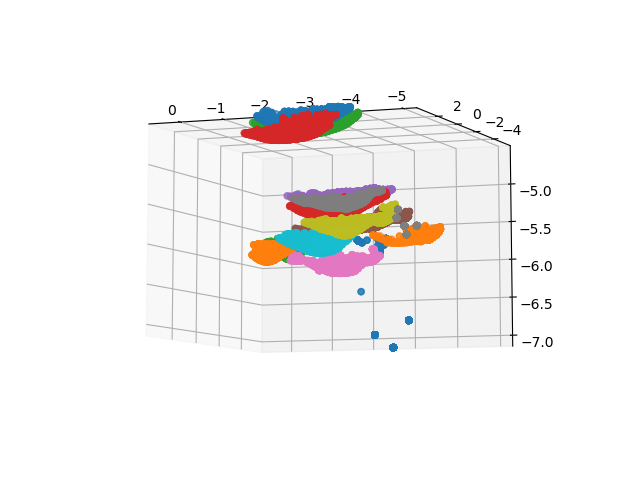

In [45]:
np.random.seed(2020)

bigboy = []
n_downsampled = 1700
initial_guess_id = 0


for seg_path, identifier in segmentation_list[:-1]:
    keep_id = 4
    identifier = identifier.replace(" ", "")
    
    point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    point_cloud = point_cloud - np.mean(point_cloud, axis=0)
    if "LT" in identifier: 
        point_cloud[:,0] = -1.*point_cloud[:,0]
        
    nrow, ncol = point_cloud.shape
#     point_cloud = np.transpose(point_cloud).reshape(nrow*ncol)
    bigboy.append(point_cloud)


mappings = correspondences(bigboy, initial_guess_id=initial_guess_id, n_downsampled=n_downsampled)

feature_array = []
# print('--')
for mapping, raw in zip(mappings, bigboy): 
    print(mapping.shape)
#     print(raw.shape)
    feature_array.append(raw[mapping])

print [arr.shape for arr in feature_array]
feature_array = np.array(feature_array)
print(feature_array.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for shape in feature_array: 
    ax.scatter(shape[:,0], shape[:,1], shape[:,2])
# aligned = procrustes_loop(feature_array, tol=.001, initial_guess_id=initial_guess_id)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for shape in aligned:
# #     shape = shape.reshape((n_downsampled, 3), order="F")
#     ax.scatter(shape[:,0], shape[:,1], shape[:,2])

In [ ]:
nshape, nfeat = aligned.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

corresponded_mean_shape = np.mean(aligned.reshape((nshape, nfeat/3, 3), order="F"), axis=0)
print corresponded_mean_shape.shape
ax.scatter(corresponded_mean_shape[:,0], corresponded_mean_shape[:,1], corresponded_mean_shape[:,2])

In [ ]:
bigboy = []
n_downsampled = 1000
np.random.seed(2020)

for seg_path, identifier in segmentation_list[:-1]:
    keep_id = 4
    identifier = identifier.replace(" ", "")
    
    point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices = np.random.randint(0, point_cloud.shape[0]-1, size=n_downsampled)
    point_cloud = point_cloud - np.mean(point_cloud, axis=0)
    if "LT" in identifier: 
        point_cloud[:,0] = -1.*point_cloud[:,0]
    
    point_cloud = point_cloud[indices]
    nrow, ncol = point_cloud.shape
    point_cloud = np.transpose(point_cloud).reshape(nrow*ncol)
    point_cloud.shape
    bigboy.append(point_cloud)

feature_array = np.array(bigboy)
feature_array.shape
    
    
    

In [ ]:
u, s, vh = np.linalg.svd(aligned, full_matrices=False)
u.shape, s.shape, vh.shape

In [ ]:
# vh = vh.reshape(n_downsampled, 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for pc in vh[:1]:
    pc = pc.reshape((vh.shape[-1]/3, 3), order="F")
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2])

# projected = np.matmul(aligned, vh[:1,:].T)
# # projected.shape
# first_pc = vh[3].reshape((n_downsampled, 3), order="F")
# ax.scatter(first_pc[:, 0], first_pc[:, 1], first_pc[:, 2])

In [ ]:
np.square(s)/np.sum(np.square(s))


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(s)), np.square(s)/np.sum(np.square(s)))
ax.set_xlabel("Principal Component Number")
ax.set_ylabel("Percentage of Variance Explained")
ax.set_title("Variance Explained by Each PC")